# 한글폰트

In [ ]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
# 여기까지 실행 후 "런타임 다시 시작..." 실행 (이 부분은 실행할 필요 없음)

Selecting previously unselected package fonts-nanum.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install*

In [ ]:
# Tokenizer library 설치
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 38.9MB/s 


# Evn*

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

Thu May 13 10:28:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
# data_dir = '/content/drive/MyDrive/Data/nlp'
data_dir = '/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data'
os.listdir(data_dir)

['data-20210420T111231Z-001.zip',
 'kowiki',
 'kowiki_32000.model',
 'kowiki_32000.vocab',
 'kowiki_mecab_32000.model',
 'kowiki_mecab_32000.vocab',
 'nsmc']

In [ ]:
qp_dir = os.path.join(data_dir, "question_pair")
if not os.path.isdir(qp_dir):
    os.makedirs(qp_dir)
os.listdir(qp_dir)

[]

# Tutorial

In [ ]:
# 입력 문장
sentences = [
    ['나는 오늘 기분이 좋아', '나는 오늘 우울해'],
    ['나는 오늘 행복해', '나는 오늘 즐거워'],
]

# 출력 정답
labels = [0, 1]  # 같음(1), 다름(0)

In [ ]:
input1 = ['나는 오늘 기분이 좋아', '나는 오늘 행복해']
input2 = ['나는 오늘 우울해', '나는 오늘 즐거워']

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for pair in sentences:
    for sentence in pair:
        words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

In [ ]:
# 학습용 입력 데이터 생성
train_inputs_1, train_inputs_2 = [], []
for pair in sentences:
    train_inputs_1.append([word_to_id[word] for word in pair[0].split()])
    train_inputs_2.append([word_to_id[word] for word in pair[1].split()])
train_inputs_1, train_inputs_2 

In [ ]:
# train label
train_labels = labels
train_labels

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_inputs_1:
    row += [0] * (4 - len(row))
train_inputs_1

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 3)
for row in train_inputs_2:
    row += [0] * (3 - len(row))
train_inputs_2

In [ ]:
# train inputs을 numpy array로 변환
train_inputs_1 = np.array(train_inputs_1)
train_inputs_2 = np.array(train_inputs_2)

# 학습용 정답을 numpy array로 변환
train_labels = np.array(train_labels)

train_inputs_1, train_inputs_2, train_labels

In [ ]:
# 입력 단어를 vector로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 3)
hidden_1 = embedding(train_inputs_1)  # (bs, n_seq_1, 3)
hidden_2 = embedding(train_inputs_2)  # (bs, n_seq_2, 3)
hidden_1, hidden_2

In [ ]:
weight, = embedding.get_weights()
weight

In [ ]:
# RNN, CNN

In [ ]:
# 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
pool = tf.keras.layers.GlobalMaxPool1D()
hidden_pool_1 = pool(hidden_1)  # (bs, 3)
hidden_pool_2 = pool(hidden_2)  # (bs, 3)
hidden_pool_1, hidden_pool_2

In [ ]:
# distance
distance = hidden_pool_1 - hidden_pool_2
distance

In [ ]:
# 문장 vector를 이용해서 같음(1), 다름(0) 확률값 예측
linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
y_pred = linear(distance)
y_pred

In [ ]:
weight, bias = linear.get_weights()
weight.shape, bias.shape

In [ ]:
# CE loss
tf.keras.losses.SparseCategoricalCrossentropy()(train_labels, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7045428>

In [ ]:
# CE loss 직접 계산: y_true
y_true = tf.one_hot(train_labels, 2)
y_true

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.]], dtype=float32)>

In [ ]:
# CE loss 직접 계산
loss1 = - y_true * tf.math.log(y_pred)
loss1

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.69534117, 0.        ],
       [0.        , 0.7137445 ]], dtype=float32)>

In [ ]:
# CE loss 직접 계산
loss2 = tf.reduce_sum(loss1, axis=-1)
loss2

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.69534117, 0.7137445 ], dtype=float32)>

In [ ]:
# CE loss 직접 계산
loss = tf.reduce_mean(loss2)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.7045429>

In [ ]:
args.n_vocab = len(word_to_id)
args.d_model = 32
args.n_out = 2
args

Namespace(d_model=32, n_out=2, n_vocab=9, seed=1234)

In [ ]:
def build_model_type1(args):
    inputs_1 = tf.keras.layers.Input((None,))  # (bs, n_seq_1)
    inputs_2 = tf.keras.layers.Input((None,))  # (bs, n_seq_2)

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden_1 = embedding(inputs_1)  # (bs, n_seq_1, d_model)
    hidden_2 = embedding(inputs_2)  # (bs, n_seq_2, d_model)
    #
    # RNN, CNN, Attention, Linear
    #
    hidden_1 = tf.keras.layers.GlobalMaxPooling1D()(hidden_1)  # (bs, d_model)
    hidden_2 = tf.keras.layers.GlobalMaxPooling1D()(hidden_2)  # (bs, d_model)
    distance = hidden_1 - hidden_2  # (bs, d_model)

    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(distance)  # (bs, n_out)

    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=y_pred)
    return model

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_inputs_1, train_inputs_2))

array([[0.4974713 , 0.50252867],
       [0.4930708 , 0.50692916]], dtype=float32)

# Vocabulary*

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'kowiki', 'kowiki_32000.model'))

True

# Data*

In [ ]:
!wget https://raw.githubusercontent.com/songys/Question_pair/master/kor_pair_train.csv
!wget https://raw.githubusercontent.com/songys/Question_pair/master/kor_Pair_test.csv

--2021-05-13 10:30:11--  https://raw.githubusercontent.com/songys/Question_pair/master/kor_pair_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 608164 (594K) [text/plain]
Saving to: ‘kor_pair_train.csv’

kor_pair_train.csv  100%[===================>] 593.91K  --.-KB/s    in 0.01s   

2021-05-13 10:30:11 (53.0 MB/s) - ‘kor_pair_train.csv’ saved [608164/608164]

--2021-05-13 10:30:11--  https://raw.githubusercontent.com/songys/Question_pair/master/kor_Pair_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52943 (52K

In [ ]:
id_to_label = {0: "다른 질문", 1: "같은 질문"}

# EDA

In [ ]:
df_train = pd.read_csv('kor_pair_train.csv', delimiter=',')
df_train

In [ ]:
# data 합치기
q_train = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
q_train.head(10)

## char length

In [ ]:
# document 길이 데이터
train_length = q_train.apply(len)
train_length.head(10)

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=60, range=[0, 60], facecolor='r', label='char')
plt.title('Lengh of char')
plt.xlabel('Number of char')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(train_length):4d}")
print(f"char 길이 최소:    {np.min(train_length):4d}")
print(f"char 길이 평균:    {np.mean(train_length):7.2f}")
print(f"char 길이 표준편차: {np.std(train_length):7.2f}")

char 길이 최대:      56
char 길이 최소:       1
char 길이 평균:      13.45
char 길이 표준편차:    6.31


In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

char 25/100분위:     9.00
char 50/100분위:    12.00
char 75/100분위:    17.00
char IQR:           8.00
char MAX/100분위:   29.00


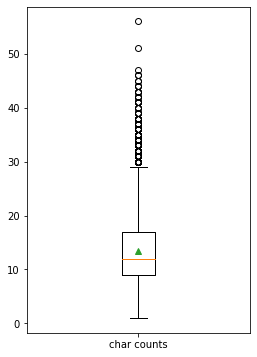

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['char counts'], showmeans=True)
plt.show()

## word length

In [ ]:
# document 길이 데이터
train_length = q_train.apply(lambda x:len(x.split()))
train_length.head(10)

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=20, range=[0, 20], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(train_length):4d}")
print(f"word 길이 최소:    {np.min(train_length):4d}")
print(f"word 길이 평균:    {np.mean(train_length):7.2f}")
print(f"word 길이 표준편차: {np.std(train_length):7.2f}")

In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['word counts'], showmeans=True)
plt.show()

## token length

In [ ]:
# document 길이 데이터
train_length = q_train.apply(lambda x:len(vocab.encode_as_pieces(x)))
train_length.head(10)

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=30, range=[0, 30], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"token 길이 최대:    {np.max(train_length):4d}")
print(f"token 길이 최소:    {np.min(train_length):4d}")
print(f"token 길이 평균:    {np.mean(train_length):7.2f}")
print(f"token 길이 표준편차: {np.std(train_length):7.2f}")

In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"token 25/100분위:  {percentile25:7.2f}")
print(f"token 50/100분위:  {percentile50:7.2f}")
print(f"token 75/100분위:  {percentile75:7.2f}")
print(f"token IQR:        {percentileIQR:7.2f}")
print(f"token MAX/100분위: {percentileMAX:7.2f}")

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['token counts'], showmeans=True)
plt.show()

## Label Count

In [ ]:
label_count = df_train['is_duplicate'].value_counts()
label_count

In [ ]:
# label count
print(f"같은 질문 개수: {label_count[0]}")
print(f"다른 질문 개수: {label_count[1]}")

In [ ]:
# 한글 설정
plt.rc('font', family="NanumBarunGothic")
plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결
plt.bar(["같음", "다름"], label_count)
plt.show()

In [ ]:
# 같음과 다름 데이타를 밸런스하게 맞추기
train_sam_data = df_train.loc[df_train['is_duplicate'] == 1]
train_nos_data = df_train.loc[df_train['is_duplicate'] == 0]
class_difference = len(train_nos_data) - len(train_sam_data)
sample_frac = 1 - (class_difference / len(train_nos_data))
train_nos_data = train_nos_data.sample(frac = sample_frac)
print("같은 질문 갯수: {}".format(len(train_sam_data)))
print("다른 질문 갯수: {}".format(len(train_nos_data)))

같은 질문 갯수: 2138
다른 질문 갯수: 2138


## Word Cloud

In [ ]:
train_question = [question for question in q_train if type(question) is str]
train_question[:10]

['1000일 만난 여자친구와 이별',
 '10년 연애사 되돌아보니 다 부질없네',
 '10년만나다 헤어지네',
 '10월의 마지막밤 . 더 보고싶네 그사람',
 '14년의 기나긴 이야기.',
 '15년만에 쓰는 편지.',
 '1년 반.',
 '1년동거 끝에 헤어짐',
 '1년만에 다시헤어지게 됐네',
 '1년을 넘게 만났는데 어떻게 이럽니까']

In [ ]:
from wordcloud import WordCloud

In [ ]:
" ".join(train_question[:10])

'1000일 만난 여자친구와 이별 10년 연애사 되돌아보니 다 부질없네 10년만나다 헤어지네 10월의 마지막밤 . 더 보고싶네 그사람 14년의 기나긴 이야기. 15년만에 쓰는 편지. 1년 반. 1년동거 끝에 헤어짐 1년만에 다시헤어지게 됐네 1년을 넘게 만났는데 어떻게 이럽니까'

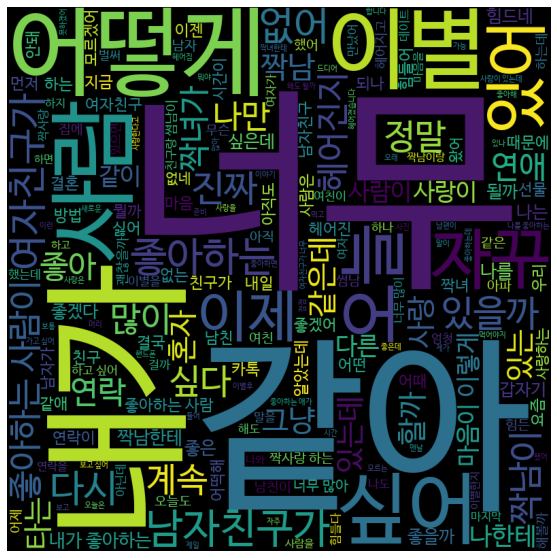

In [ ]:
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(" ".join(train_question))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Small Data Project (Type1)

## Train, Test 데이터 생성

In [ ]:
df_train = pd.read_csv('kor_pair_train.csv', delimiter=',')
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [ ]:
df_train = df_train.dropna()
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [ ]:
df_train = df_train.sample(10)
df_train

,id,qid1,qid2,question1,question2,is_duplicate
3713,3714,7427,7428,어이가 없어서,어이없어,0
208,209,417,418,결국 헤어짐이 찾아오네,결혼 가치관 때문에 헤어졌네.,1
2600,2601,5201,5202,사랑을 믿으세요?,사랑이 끝나고 할 일?,1
2664,2665,5329,5330,사랑하는 사람이 떠난대,내가 사랑하는 사람이 떠난대,0
2055,2056,4111,4112,목표가 없어,목표가 없어서 걱정임,0
3371,3372,6743,6744,썸남한테 크리스마스 선물 오바?,썸남한테 크리스마스 선물 오바?,0
3059,3060,6119,6120,스키장 간다!,주말에 스키장 간다!,0
6025,6026,12051,12052,착한남자.너무 쿨하지못한남자 매력없어.,참 답 없는 나란 놈.,1
4051,4052,8103,8104,연락했는데,연애하는 것도 기술이 필요한가봐,1
688,689,1377,1378,나 잘하고 있는 걸까?,나 잘하고 있는 건지 모르겠어,0


In [ ]:
df_test = pd.read_csv('kor_Pair_test.csv', delimiter=',')
df_test

,test_id,question1,question2,is_duplicate,Unnamed: 4
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1,NaN
1,2,2년 가량의 연애,2년 만났어,0,NaN
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0,NaN
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1,NaN
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1,NaN
...,...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1.0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1,NaN
685,686,휴대폰 액정 깨졌어,액정 깨짐,0,NaN
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1,NaN


In [ ]:
df_test.dropna()

,test_id,question1,question2,is_duplicate,Unnamed: 4
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1.0


In [ ]:
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [ ]:
df_test = df_test.dropna()
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [ ]:
df_test = df_test.sample(10)
df_test

,test_id,question1,question2,is_duplicate
138,139,노래 불러줘,웃긴게 장난없음,1
423,424,오늘 화장 좀 잘된다,부모님이 허락 안해주셔,1
224,225,뭐 이렇게 끝나냐,마지막 문자 보냄,1
499,500,잘 다녀왔습니다,백만년만에 만난 친구랑 스테이크 먹었어,1
238,239,배 아파서 누워있어,회사가기 싫어,1
503,504,잠수타는거 너무 짜증나,아 좀 전화 좀 받으라고,1
309,310,셀프웨딩 어떨까?,셀프웨딩으로 준비 해볼까,0
343,344,썸인 것 같아,썸 타다가 자연스럽게 사귀는 방법,1
489,490,자꾸 궁금한데 집착일까,집착한다고 할까봐 문자 못하겠어,1
366,367,아직 보내지 못한 이별편지,마지막이라니 울고 싶다.,1


In [ ]:
def make_data(df, vocab, n_seq):
    inputs_1, inputs_2, labels = [], [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        is_duplicate = 1 - row["is_duplicate"]  # 0 -> 1, 1 -> 0

        question1 = row["question1"]
        token1 = vocab.encode_as_ids(question1)[:n_seq]
        token1 = token1 + [0] * (n_seq - len(token1))

        question2 = row["question2"]
        token2 = vocab.encode_as_ids(question2)[:n_seq]
        token2 = token2 + [0] * (n_seq - len(token2))

        assert len(token1) == n_seq
        assert len(token2) == n_seq

        print(is_duplicate, len(token1), token1, len(token2), token2)
        
        inputs_1.append(token1)
        inputs_2.append(token2)
        labels.append(is_duplicate)

    inputs_1 = np.array(inputs_1)
    inputs_2 = np.array(inputs_2)
    labels = np.array(labels)
    return inputs_1, inputs_2, labels

In [ ]:
train_inputs_1, train_inputs_2, train_labels = make_data(df_train, vocab, 16)
train_inputs_1, train_inputs_2, train_labels

1 16 [542, 20, 19, 11176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [542, 20, 15358, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [500, 9250, 5394, 20, 19690, 377, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [1113, 22598, 135, 9250, 10540, 377, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [5251, 10, 31977, 2607, 17059, 2138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [1599, 20, 7562, 292, 289, 2138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 16 [15032, 1316, 8216, 76, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [6484, 15032, 1316, 8216, 76, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 16 [3795, 19, 2908, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [3795, 19, 11176, 10441, 884, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 16 [10, 27556, 486, 10173, 10448, 5417, 200, 291, 2138, 0, 0, 0, 0, 0, 0, 0] 16 [10, 27556, 486, 10173, 10448, 5417, 200, 291, 2138, 0, 0, 0, 0, 0, 0, 0]
1 16 [6019, 159, 6268, 1217, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [6797, 14, 6019, 159, 6268, 1217, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [5650, 33, 22197, 7, 866, 252, 9310, 204, 11453, 

(array([[  542,    20,    19, 11176,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  500,  9250,  5394,    20, 19690,   377,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [ 5251,    10, 31977,  2607, 17059,  2138,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [15032,  1316,  8216,    76,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [ 3795,    19,  2908,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [   10, 27556,   486, 10173, 10448,  5417,   200,   291,  2138,
             0,     0,     0,     0,     0,     0,     0],
        [ 6019,   159,  6268,  1217,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [ 5650,    33, 22197,     7,   866,   252,  9310,   204, 11453,
           

In [ ]:
test_inputs_1, test_inputs_2, test_labels = make_data(df_test, vocab, 16)
test_inputs_1, test_inputs_2, test_labels

0 16 [864, 2995, 14662, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [8834, 1912, 87, 14214, 15358, 585, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [10695, 15418, 3304, 423, 281, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [10632, 20, 5081, 298, 61, 106, 2646, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [21397, 1670, 5471, 1942, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [855, 1818, 372, 15273, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [423, 311, 1110, 18570, 5049, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [10, 5661, 6813, 6123, 2091, 828, 27088, 3977, 32005, 107, 0, 0, 0, 0, 0, 0]
0 16 [617, 23757, 71, 1705, 1290, 14426, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [10876, 51, 10219, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [21590, 206, 12, 435, 2364, 6054, 892, 57, 0, 0, 0, 0, 0, 0, 0, 0] 16 [199, 3304, 3993, 3304, 22740, 143, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 16 [24881, 5814, 2719, 542, 23828, 3083, 2138, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [24881, 5814, 2719, 27, 1566, 209, 1564, 3083, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [10, 27556, 29, 444, 1438

(array([[  864,  2995, 14662,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [10695, 15418,  3304,   423,   281,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [21397,  1670,  5471,  1942,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  423,   311,  1110, 18570,  5049,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  617, 23757,    71,  1705,  1290, 14426,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [21590,   206,    12,   435,  2364,  6054,   892,    57,     0,
             0,     0,     0,     0,     0,     0,     0],
        [24881,  5814,  2719,   542, 23828,  3083,  2138,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [   10, 27556,    29,   444, 14380,     0,     0,     0,     0,
           

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args.n_out = 2
args

Namespace(d_model=256, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
def build_model_type1(args):
    inputs_1 = tf.keras.layers.Input((None,)) # (bs,n_Seq_1), (bs, 100)
    inputs_2 = tf.keras.layers.Input((None,)) # (bs,n_seq_2), (bs, 90)

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden_1 = embedding(inputs_1)
    hidden_2 = embedding(inputs_2)
    #
    # RNN, CNN, Attention, Linear
    #
    pool = tf.keras.layers.GlobalMaxPooling1D() # global pooling을 하면 N_seq가 달라도 사라지니까 
    hidden_1 = pool(hidden_1)#  같이 넣거나 뺄수 있다
    hidden_2 = pool(hidden_2) #(bs, d_model)
    distance = hidden_1 - hidden_2 # (bs, d_model)

    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(distance) # (bs, n_out)

    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=y_pred)
    return model

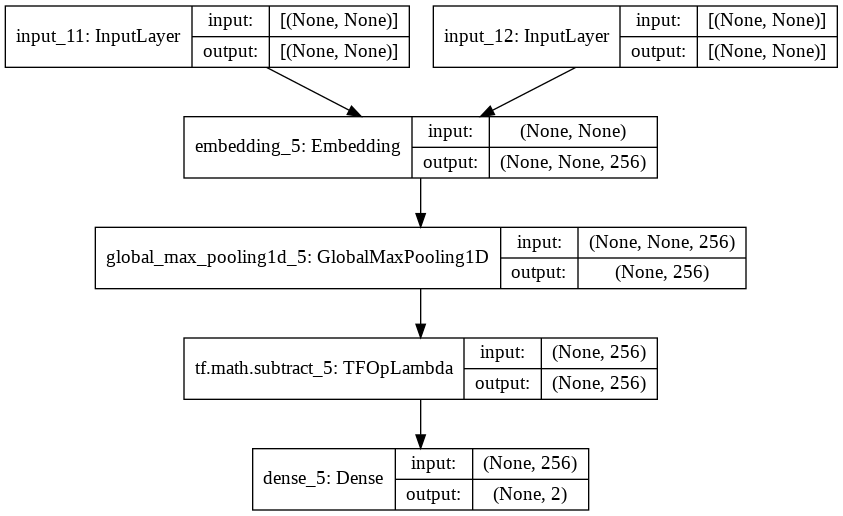

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_inputs_1[:4], train_inputs_2[:4]))

array([[0.49218038, 0.50781965],
       [0.49550992, 0.5044901 ],
       [0.49860597, 0.50139403],
       [0.49740884, 0.5025912 ]], dtype=float32)

In [ ]:
model.predict((test_inputs_1[:4], test_inputs_2[:4]))

array([[0.50195706, 0.4980429 ],
       [0.4912372 , 0.5087628 ],
       [0.5044786 , 0.4955214 ],
       [0.47879857, 0.52120143]], dtype=float32)

## Train

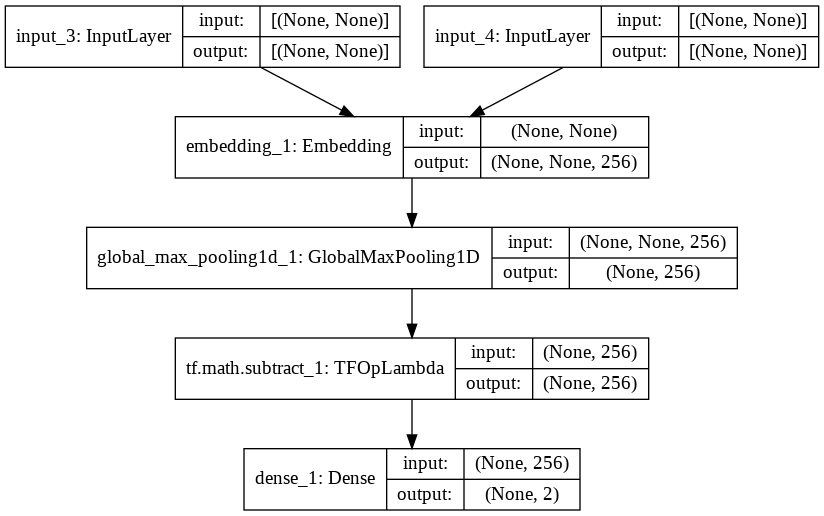

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(qp_dir, "type1.hdf5"), # qd_dir밑으로 type1 저장할게
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True) # 가끔가다 로딩이 잘 안될때가 있대
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(qp_dir, "type1.csv"))

In [ ]:
history = model.fit((train_inputs_1, train_inputs_2), train_labels,
                    epochs=100,
                    batch_size=512, # 사전학습할때는 큰게 좋고, task할때는 적은 값이 좋다
                    validation_data=((test_inputs_1, test_inputs_2), test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
1/1 [==============================] - 1s 991ms/step - loss: 0.6919 - accuracy: 0.5000 - val_loss: 0.6969 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/question_pair/type1.hdf5
Epoch 2/100
1/1 [==============================] - 0s 160ms/step - loss: 0.6787 - accuracy: 0.9000 - val_loss: 0.6976 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/100
1/1 [==============================] - 0s 111ms/step - loss: 0.6660 - accuracy: 1.0000 - val_loss: 0.6981 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/100
1/1 [==============================] - 0s 108ms/step - loss: 0.6537 - accuracy: 1.0000 - val_loss: 0.6988 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.50000
Epoch 5/100
1/1 [==============================] - 0s 164ms/step - loss: 0.6418 - accuracy: 1.0000 - val_loss: 0.

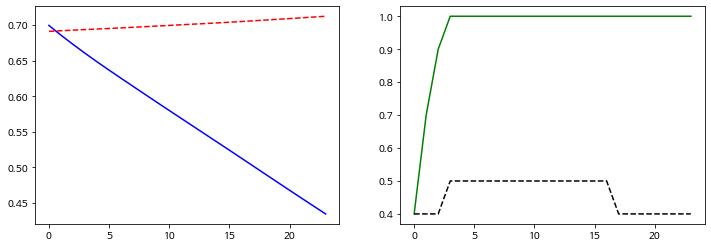

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(qp_dir, "type1.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate((test_inputs_1, test_inputs_2), test_labels)

# input으로 꼭 tuple로 줘야한다

1/1 [==============================] - 0s 170ms/step - loss: 0.6969 - accuracy: 0.5000


[0.6969453692436218, 0.5]

In [ ]:
y_pred = model.predict((test_inputs_1, test_inputs_2))
y_pred

# input으로 꼭 tuple로 줘야한다

array([[0.48296803, 0.51703197],
       [0.4866979 , 0.5133021 ],
       [0.5038641 , 0.49613592],
       [0.4938379 , 0.5061621 ],
       [0.5036498 , 0.49635023],
       [0.5054846 , 0.4945154 ],
       [0.49622536, 0.5037746 ],
       [0.4969108 , 0.5030892 ],
       [0.4927715 , 0.5072285 ],
       [0.5118374 , 0.48816258]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([1, 1, 0, 1, 0, 0, 1, 1, 1, 0])

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[4, 5],
       [0, 1]])

In [ ]:
# 꼭 confuse matrix 다확인해보자
# inbalance

tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.5
precision: 0.16666666666666666
recall: 1.0
f1: 0.2857142857142857


## 배포

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(qp_dir, "type1.hdf5"))

In [ ]:
string1 = "영화 너무 심심해"
string2 = "영화 너무 재미지고 좋았어"

In [ ]:
vocab.encode_as_pieces(string1), vocab.encode_as_pieces(string2)

(['▁영화', '▁너무', '▁심', '심', '해'], ['▁영화', '▁너무', '▁재미', '지고', '▁좋았', '어'])

In [ ]:
infer_input_1 = vocab.encode_as_ids(string1)
infer_input_1 = np.array([infer_input_1])
infer_input_1

array([[ 283, 2364,  732,  690,   61]])

In [ ]:
infer_input_2 = vocab.encode_as_ids(string2)
infer_input_2 = np.array([infer_input_2])
infer_input_2

array([[  283,  2364, 16850,  3132, 19271,   107]])

In [ ]:
y_pred = model.predict((infer_input_1, infer_input_2))
y_pred

array([[0.50408614, 0.49591386]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)[0]
y_class

0

In [ ]:
print(f"{string1} / {string2} : {id_to_label[y_class]}")

영화 너무 심심해 / 영화 너무 재미지고 좋았어 : 다른 질문


In [ ]:
def do_predict(model, string1, string2):
    infer_input_1 = vocab.encode_as_ids(string1)
    infer_input_1 = np.array([infer_input_1]) # [] 하는 이유는 batch size = 1이라는거지

    infer_input_2 = vocab.encode_as_ids(string2)
    infer_input_2 = np.array([infer_input_2])

    y_pred = model.predict((infer_input_1, infer_input_2))
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]
    # return y_class

In [ ]:
do_predict(model, string1, string2)

'다른 질문'

In [ ]:
while True:
    print("input 1> ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("input 2> ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    result = do_predict(model, string1, string2)
    print(result)

input 1> 어렵다 어려워
input 2> 너무 많이 먹엇네
다른 질문
input 1> 음
input 2> 


# Big Data Project (Type1)

## Train, Test 데이터 생성

In [ ]:
df_train = pd.read_csv('kor_pair_train.csv', delimiter=',')
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [ ]:
df_train = df_train.dropna()
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [ ]:
df_test = pd.read_csv('kor_Pair_test.csv', delimiter=',')
df_test

,test_id,question1,question2,is_duplicate,Unnamed: 4
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1,NaN
1,2,2년 가량의 연애,2년 만났어,0,NaN
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0,NaN
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1,NaN
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1,NaN
...,...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1.0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1,NaN
685,686,휴대폰 액정 깨졌어,액정 깨짐,0,NaN
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1,NaN


In [ ]:
df_test.dropna()

,test_id,question1,question2,is_duplicate,Unnamed: 4
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1.0


In [ ]:
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [ ]:
df_test = df_test.dropna()
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [ ]:
def make_data(df, vocab, n_seq):
    inputs_1, inputs_2, labels = [], [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        is_duplicate = 1 - row["is_duplicate"]  # 0 -> 1, 1 -> 0

        question1 = row["question1"]
        token1 = vocab.encode_as_ids(question1)[:n_seq]
        token1 = token1 + [0] * (n_seq - len(token1))

        question2 = row["question2"]
        token2 = vocab.encode_as_ids(question2)[:n_seq]
        token2 = token2 + [0] * (n_seq - len(token2))

        assert len(token1) == n_seq
        assert len(token2) == n_seq

        print(is_duplicate, len(token1), token1, len(token2), token2)
        
        inputs_1.append(token1)
        inputs_2.append(token2)
        labels.append(is_duplicate)

    inputs_1 = np.array(inputs_1)
    inputs_2 = np.array(inputs_2)
    labels = np.array(labels)
    return inputs_1, inputs_2, labels

In [ ]:
train_inputs_1, train_inputs_2, train_labels = make_data(df_train, vocab, 16)
train_inputs_1, train_inputs_2, train_labels

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1 16 [8913, 27119, 4387, 21, 423, 11457, 133, 1472, 104, 21341, 2138, 0, 0, 0, 0, 0] 16 [10742, 4387, 21, 423, 2837, 11, 3083, 2138, 0, 0, 0, 0, 0, 0, 0, 0]
1 16 [9497, 3581, 1530, 984, 21584, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [9497, 3581, 1530, 984, 423, 10020, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 16 [10, 18957, 205, 159, 10, 5609, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [10, 18957, 205, 159, 10, 31891, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 16 [10, 18957, 400, 414, 11072, 10, 11640, 12, 386, 0, 0, 0, 0, 0, 0, 0] 16 [10, 18957, 400, 520, 10, 11640, 12, 386, 0, 0, 0, 0, 0, 0, 0, 0]
1 16 [10, 18957, 2507, 414, 11072, 10, 11640, 12, 510, 1625, 10, 31860, 41, 0, 0, 0] 16 [26510, 19, 10, 18957, 2507, 2364, 520, 6152, 782, 0, 0, 0, 0, 0, 0, 0]
1 16 [2105, 7840, 1192, 19, 19239, 680, 542, 23253, 277, 6415, 7, 0, 0, 0, 0, 0] 16 [7840, 1192, 19, 2105, 18384, 379, 542, 23253, 277, 6415, 7, 0, 0, 0, 0, 0]
0 16 [12964, 2434, 693, 12780, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

(array([[ 4163,    30,  6123, ...,     0,     0,     0],
        [   67,    17,  7479, ...,     0,     0,     0],
        [   67,    17,    59, ...,     0,     0,     0],
        ...,
        [22410,    10,    15, ...,     0,     0,     0],
        [22410,  1034,  4274, ...,     0,     0,     0],
        [ 2425, 13884,    23, ...,     0,     0,     0]]),
 array([[   67,    17, 10200, ...,     0,     0,     0],
        [   67,    17,   210, ...,     0,     0,     0],
        [  246,    17,    79, ...,     0,     0,     0],
        ...,
        [ 5832,   199, 11074, ...,     0,     0,     0],
        [22410,  1034,  4274, ...,     0,     0,     0],
        [20650, 21957,  2364, ...,     0,     0,     0]]),
 array([0, 0, 0, ..., 0, 1, 0]))

In [ ]:
test_inputs_1, test_inputs_2, test_labels = make_data(df_test, vocab, 16)
test_inputs_1, test_inputs_2, test_labels

0 16 [531, 12785, 15185, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [5251, 1530, 1932, 87, 5136, 4426, 57, 506, 2138, 0, 0, 0, 0, 0, 0, 0]
1 16 [38, 17, 5960, 8, 7479, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [38, 17, 13297, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 16 [38, 17, 6123, 2025, 30, 20, 187, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [1074, 27731, 38, 17, 337, 227, 31560, 107, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [38, 17, 19010, 3113, 1113, 2265, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [38, 20652, 29598, 42, 1316, 501, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [54, 462, 120, 2813, 349, 828, 3384, 4247, 13655, 2768, 506, 2138, 0, 0, 0, 0] 16 [17579, 864, 5251, 166, 6399, 29, 6119, 3068, 379, 0, 0, 0, 0, 0, 0, 0]
0 16 [77, 17, 20, 300, 31997, 680, 1497, 5627, 15524, 27879, 61, 924, 0, 0, 0, 0] 16 [27731, 31, 1009, 33, 44, 77, 1224, 12327, 377, 0, 0, 0, 0, 0, 0, 0]
1 16 [2058, 4416, 349, 148, 1847, 3083, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [5217, 10, 1, 479, 11223, 9610, 21, 16032, 3083, 0, 0, 0, 0, 0, 0, 0]
0 16 [176

(array([[  531, 12785, 15185, ...,     0,     0,     0],
        [   38,    17,  5960, ...,     0,     0,     0],
        [   38,    17,  6123, ...,     0,     0,     0],
        ...,
        [18402, 26008,  5563, ...,     0,     0,     0],
        [10149,  2156,  2364, ...,     0,     0,     0],
        [   10, 11734,    32, ...,     0,     0,     0]]),
 array([[ 5251,  1530,  1932, ...,     0,     0,     0],
        [   38,    17, 13297, ...,     0,     0,     0],
        [ 1074, 27731,    38, ...,     0,     0,     0],
        ...,
        [26008,  5563,  5394, ...,     0,     0,     0],
        [   10, 31855, 14969, ...,     0,     0,     0],
        [ 1118,  3327,    18, ...,     0,     0,     0]]),
 array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args.n_out = 2
args

Namespace(d_model=256, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
def build_model_type1(args):
    inputs_1 = tf.keras.layers.Input((None,)) # (bs,n_Seq_1), (bs, 100)
    inputs_2 = tf.keras.layers.Input((None,)) # (bs,n_seq_2), (bs, 90)

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden_1 = embedding(inputs_1)
    hidden_2 = embedding(inputs_2)
    #
    # RNN, CNN, Attention, Linear
    #
    pool = tf.keras.layers.GlobalMaxPooling1D() # global pooling을 하면 N_seq가 달라도 사라지니까 
    hidden_1 = pool(hidden_1)#  같이 넣거나 뺄수 있다
    hidden_2 = pool(hidden_2) #(bs, d_model)
    distance = hidden_1 - hidden_2 # (bs, d_model)

    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(distance) # (bs, n_out)

    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=y_pred)
    return model

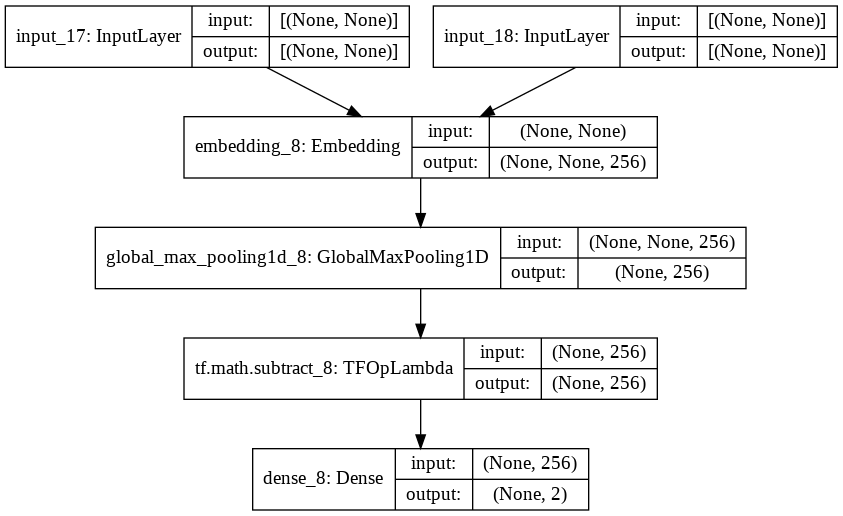

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_inputs_1[:4], train_inputs_2[:4]))

array([[0.5089839 , 0.4910161 ],
       [0.49245593, 0.50754404],
       [0.5010607 , 0.4989393 ],
       [0.50272787, 0.49727213]], dtype=float32)

In [ ]:
model.predict((test_inputs_1[:4], test_inputs_2[:4]))

array([[0.5025716 , 0.49742842],
       [0.5016285 , 0.49837148],
       [0.5019757 , 0.49802423],
       [0.50564474, 0.4943553 ]], dtype=float32)

## Train

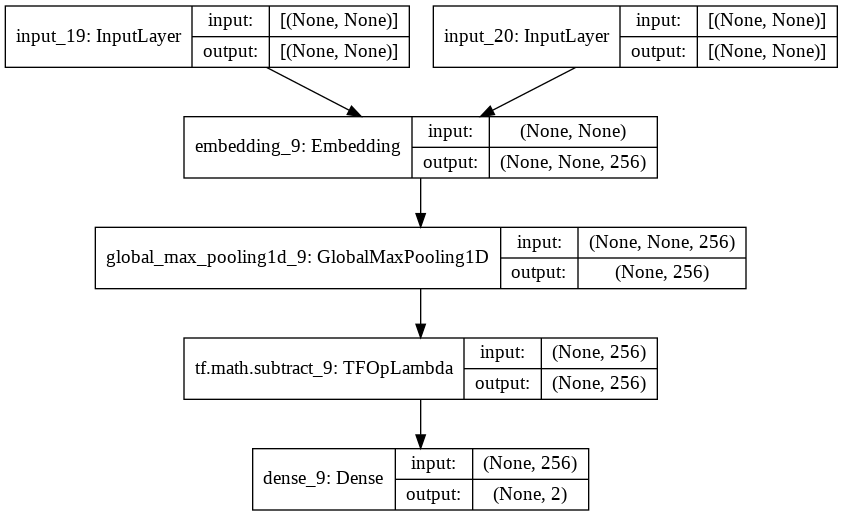

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(qp_dir, "type1.hdf5"), # qd_dir밑으로 type1 저장할게
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True) # 가끔가다 로딩이 잘 안될때가 있대
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(qp_dir, "type1.csv"))

In [ ]:
history = model.fit((train_inputs_1, train_inputs_2), train_labels,
                    epochs=100,
                    batch_size=512, # 사전학습할때는 큰게 좋고, task할때는 적은 값이 좋다
                    validation_data=((test_inputs_1, test_inputs_2), test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
14/14 [==============================] - 2s 105ms/step - loss: 0.6908 - accuracy: 0.5942 - val_loss: 0.6918 - val_accuracy: 0.5363

Epoch 00001: val_accuracy improved from -inf to 0.53634, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/question_pair/type1.hdf5
Epoch 2/100
14/14 [==============================] - 1s 91ms/step - loss: 0.6699 - accuracy: 0.7903 - val_loss: 0.6922 - val_accuracy: 0.5291

Epoch 00002: val_accuracy did not improve from 0.53634
Epoch 3/100
14/14 [==============================] - 1s 87ms/step - loss: 0.6458 - accuracy: 0.8244 - val_loss: 0.6938 - val_accuracy: 0.5305

Epoch 00003: val_accuracy did not improve from 0.53634
Epoch 4/100
14/14 [==============================] - 1s 86ms/step - loss: 0.6133 - accuracy: 0.8386 - val_loss: 0.6987 - val_accuracy: 0.5291

Epoch 00004: val_accuracy did not improve from 0.53634
Epoch 5/100
14/14 [==============================] - 1s 89ms/step - loss: 0.5756 - accuracy: 0.8550 - val_lo

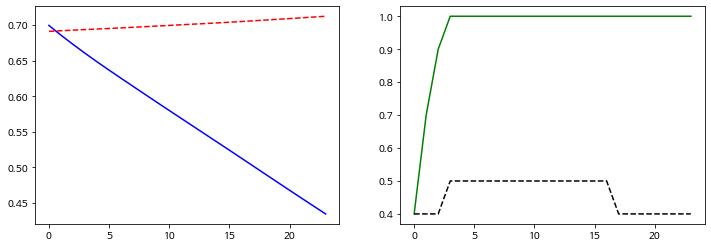

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(qp_dir, "type1.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate((test_inputs_1, test_inputs_2), test_labels)

# input으로 꼭 tuple로 줘야한다

1/1 [==============================] - 0s 170ms/step - loss: 0.6969 - accuracy: 0.5000


[0.6969453692436218, 0.5]

In [ ]:
y_pred = model.predict((test_inputs_1, test_inputs_2))
y_pred

# input으로 꼭 tuple로 줘야한다

array([[0.48296803, 0.51703197],
       [0.4866979 , 0.5133021 ],
       [0.5038641 , 0.49613592],
       [0.4938379 , 0.5061621 ],
       [0.5036498 , 0.49635023],
       [0.5054846 , 0.4945154 ],
       [0.49622536, 0.5037746 ],
       [0.4969108 , 0.5030892 ],
       [0.4927715 , 0.5072285 ],
       [0.5118374 , 0.48816258]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([1, 1, 0, 1, 0, 0, 1, 1, 1, 0])

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[4, 5],
       [0, 1]])

In [ ]:
# 꼭 confuse matrix 다확인해보자
# inbalance

tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.5
precision: 0.16666666666666666
recall: 1.0
f1: 0.2857142857142857


## 배포

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(qp_dir, "type1.hdf5"))

In [ ]:
string1 = "영화 너무 심심해"
string2 = "영화 너무 재미지고 좋았어"

In [ ]:
vocab.encode_as_pieces(string1), vocab.encode_as_pieces(string2)

(['▁영화', '▁너무', '▁심', '심', '해'], ['▁영화', '▁너무', '▁재미', '지고', '▁좋았', '어'])

In [ ]:
infer_input_1 = vocab.encode_as_ids(string1)
infer_input_1 = np.array([infer_input_1])
infer_input_1

array([[ 283, 2364,  732,  690,   61]])

In [ ]:
infer_input_2 = vocab.encode_as_ids(string2)
infer_input_2 = np.array([infer_input_2])
infer_input_2

array([[  283,  2364, 16850,  3132, 19271,   107]])

In [ ]:
y_pred = model.predict((infer_input_1, infer_input_2))
y_pred

array([[0.50408614, 0.49591386]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)[0]
y_class

0

In [ ]:
print(f"{string1} / {string2} : {id_to_label[y_class]}")

영화 너무 심심해 / 영화 너무 재미지고 좋았어 : 다른 질문


In [ ]:
def do_predict(model, string1, string2):
    infer_input_1 = vocab.encode_as_ids(string1)
    infer_input_1 = np.array([infer_input_1]) # [] 하는 이유는 batch size = 1이라는거지

    infer_input_2 = vocab.encode_as_ids(string2)
    infer_input_2 = np.array([infer_input_2])

    y_pred = model.predict((infer_input_1, infer_input_2))
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]
    # return y_class

In [ ]:
do_predict(model, string1, string2)

'다른 질문'

In [ ]:
while True:
    print("input 1> ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("input 2> ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    result = do_predict(model, string1, string2)
    print(result)

input 1> 어렵다 어려워
input 2> 너무 많이 먹엇네
다른 질문
input 1> 음
input 2> 


# Small Data Project (Type2)

## Train, Test 데이터 생성

In [ ]:
df_train = pd.read_csv('kor_pair_train.csv', delimiter=',')
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [ ]:
df_train = df_train.dropna()
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [ ]:
df_train = df_train.sample(10)
df_train

,id,qid1,qid2,question1,question2,is_duplicate
3713,3714,7427,7428,어이가 없어서,어이없어,0
208,209,417,418,결국 헤어짐이 찾아오네,결혼 가치관 때문에 헤어졌네.,1
2600,2601,5201,5202,사랑을 믿으세요?,사랑이 끝나고 할 일?,1
2664,2665,5329,5330,사랑하는 사람이 떠난대,내가 사랑하는 사람이 떠난대,0
2055,2056,4111,4112,목표가 없어,목표가 없어서 걱정임,0
3371,3372,6743,6744,썸남한테 크리스마스 선물 오바?,썸남한테 크리스마스 선물 오바?,0
3059,3060,6119,6120,스키장 간다!,주말에 스키장 간다!,0
6025,6026,12051,12052,착한남자.너무 쿨하지못한남자 매력없어.,참 답 없는 나란 놈.,1
4051,4052,8103,8104,연락했는데,연애하는 것도 기술이 필요한가봐,1
688,689,1377,1378,나 잘하고 있는 걸까?,나 잘하고 있는 건지 모르겠어,0


In [ ]:
df_test = pd.read_csv('kor_Pair_test.csv', delimiter=',')
df_test

,test_id,question1,question2,is_duplicate,Unnamed: 4
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1,NaN
1,2,2년 가량의 연애,2년 만났어,0,NaN
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0,NaN
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1,NaN
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1,NaN
...,...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1.0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1,NaN
685,686,휴대폰 액정 깨졌어,액정 깨짐,0,NaN
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1,NaN


In [ ]:
df_test.dropna()

,test_id,question1,question2,is_duplicate,Unnamed: 4
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1.0


In [ ]:
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [ ]:
df_test = df_test.dropna()
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [ ]:
df_test = df_test.sample(10)
df_test

,test_id,question1,question2,is_duplicate
138,139,노래 불러줘,웃긴게 장난없음,1
423,424,오늘 화장 좀 잘된다,부모님이 허락 안해주셔,1
224,225,뭐 이렇게 끝나냐,마지막 문자 보냄,1
499,500,잘 다녀왔습니다,백만년만에 만난 친구랑 스테이크 먹었어,1
238,239,배 아파서 누워있어,회사가기 싫어,1
503,504,잠수타는거 너무 짜증나,아 좀 전화 좀 받으라고,1
309,310,셀프웨딩 어떨까?,셀프웨딩으로 준비 해볼까,0
343,344,썸인 것 같아,썸 타다가 자연스럽게 사귀는 방법,1
489,490,자꾸 궁금한데 집착일까,집착한다고 할까봐 문자 못하겠어,1
366,367,아직 보내지 못한 이별편지,마지막이라니 울고 싶다.,1


In [ ]:
def make_data(df, vocab, n_seq):
    inputs_1, inputs_2, labels = [], [], []
    n_max = n_seq -1 # 두 문장 사이아 seperater 하나 len() =1 사라지니까
    sep_id = vocab.piece_to_id('[sep]') # 문장의 구분자


    for i, row in tqdm(df.iterrows(), total=len(df)):
        is_duplicate = 1 - row["is_duplicate"]  # 0 -> 1, 1 -> 0

        question1 = row["question1"]
        token1 = vocab.encode_as_pieces(question1)
        question2 = row["question2"]
        token2 = vocab.encode_as_pieces(question2)
        print(token1, token2)

        # len(a) + len(b) = 32-1 // 이때 1은 sep니까 한자리 필요하지
        # 이때 len(a) = 25, len(10) 이면 
        # len(a)를 커팅해주는게 일반적이지


        while n_max < len(token1) + len(token2):
            if len(token1) > len(token2):
                del token1[-1]
            else:
                del token2[-1]
        print(token1, token2)
        token = token1 + [sep_id] + token2
        print(token)
        token = token[:n_seq] # 길이를 줄임 32기준으로 보자
        token = token + [0] * (n_seq - len(token)) # padding 넣어준거고

        assert len(token) == n_seq

        inputs.append(token)
        labels.append(is_duplicate)



In [ ]:
train_inputs_1, train_inputs_2, train_labels = make_data(df_train, vocab, 16)
train_inputs_1, train_inputs_2, train_labels

1 16 [542, 20, 19, 11176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [542, 20, 15358, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [500, 9250, 5394, 20, 19690, 377, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [1113, 22598, 135, 9250, 10540, 377, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [5251, 10, 31977, 2607, 17059, 2138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [1599, 20, 7562, 292, 289, 2138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 16 [15032, 1316, 8216, 76, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [6484, 15032, 1316, 8216, 76, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 16 [3795, 19, 2908, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [3795, 19, 11176, 10441, 884, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 16 [10, 27556, 486, 10173, 10448, 5417, 200, 291, 2138, 0, 0, 0, 0, 0, 0, 0] 16 [10, 27556, 486, 10173, 10448, 5417, 200, 291, 2138, 0, 0, 0, 0, 0, 0, 0]
1 16 [6019, 159, 6268, 1217, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [6797, 14, 6019, 159, 6268, 1217, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [5650, 33, 22197, 7, 866, 252, 9310, 204, 11453, 

(array([[  542,    20,    19, 11176,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  500,  9250,  5394,    20, 19690,   377,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [ 5251,    10, 31977,  2607, 17059,  2138,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [15032,  1316,  8216,    76,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [ 3795,    19,  2908,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [   10, 27556,   486, 10173, 10448,  5417,   200,   291,  2138,
             0,     0,     0,     0,     0,     0,     0],
        [ 6019,   159,  6268,  1217,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [ 5650,    33, 22197,     7,   866,   252,  9310,   204, 11453,
           

In [ ]:
test_inputs_1, test_inputs_2, test_labels = make_data(df_test, vocab, 16)
test_inputs_1, test_inputs_2, test_labels

0 16 [864, 2995, 14662, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [8834, 1912, 87, 14214, 15358, 585, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [10695, 15418, 3304, 423, 281, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [10632, 20, 5081, 298, 61, 106, 2646, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [21397, 1670, 5471, 1942, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [855, 1818, 372, 15273, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [423, 311, 1110, 18570, 5049, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [10, 5661, 6813, 6123, 2091, 828, 27088, 3977, 32005, 107, 0, 0, 0, 0, 0, 0]
0 16 [617, 23757, 71, 1705, 1290, 14426, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [10876, 51, 10219, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [21590, 206, 12, 435, 2364, 6054, 892, 57, 0, 0, 0, 0, 0, 0, 0, 0] 16 [199, 3304, 3993, 3304, 22740, 143, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 16 [24881, 5814, 2719, 542, 23828, 3083, 2138, 0, 0, 0, 0, 0, 0, 0, 0, 0] 16 [24881, 5814, 2719, 27, 1566, 209, 1564, 3083, 0, 0, 0, 0, 0, 0, 0, 0]
0 16 [10, 27556, 29, 444, 1438

(array([[  864,  2995, 14662,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [10695, 15418,  3304,   423,   281,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [21397,  1670,  5471,  1942,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  423,   311,  1110, 18570,  5049,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  617, 23757,    71,  1705,  1290, 14426,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [21590,   206,    12,   435,  2364,  6054,   892,    57,     0,
             0,     0,     0,     0,     0,     0,     0],
        [24881,  5814,  2719,   542, 23828,  3083,  2138,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [   10, 27556,    29,   444, 14380,     0,     0,     0,     0,
           

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args.n_out = 2
args

Namespace(d_model=256, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
def build_model_type1(args):
    inputs_1 = tf.keras.layers.Input((None,)) # (bs,n_Seq_1), (bs, 100)
    inputs_2 = tf.keras.layers.Input((None,)) # (bs,n_seq_2), (bs, 90)

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden_1 = embedding(inputs_1)
    hidden_2 = embedding(inputs_2)
    #
    # RNN, CNN, Attention, Linear
    #
    pool = tf.keras.layers.GlobalMaxPooling1D() # global pooling을 하면 N_seq가 달라도 사라지니까 
    hidden_1 = pool(hidden_1)#  같이 넣거나 뺄수 있다
    hidden_2 = pool(hidden_2) #(bs, d_model)
    distance = hidden_1 - hidden_2 # (bs, d_model)
    hiddens = tf.concat([hidden_1, hiddens_2], axis = -1)

    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(distance) # (bs, n_out)

    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=y_pred)
    return model

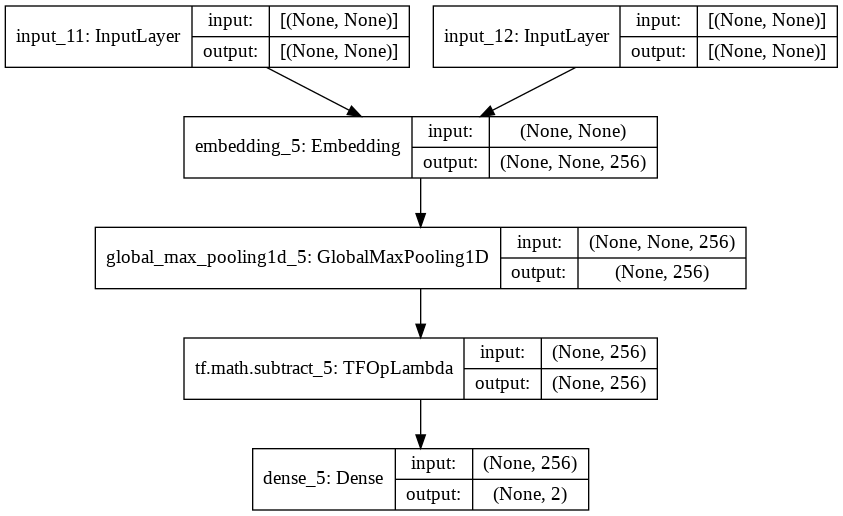

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_inputs_1[:4], train_inputs_2[:4]))

array([[0.49218038, 0.50781965],
       [0.49550992, 0.5044901 ],
       [0.49860597, 0.50139403],
       [0.49740884, 0.5025912 ]], dtype=float32)

In [ ]:
model.predict((test_inputs_1[:4], test_inputs_2[:4]))

array([[0.50195706, 0.4980429 ],
       [0.4912372 , 0.5087628 ],
       [0.5044786 , 0.4955214 ],
       [0.47879857, 0.52120143]], dtype=float32)

## Train

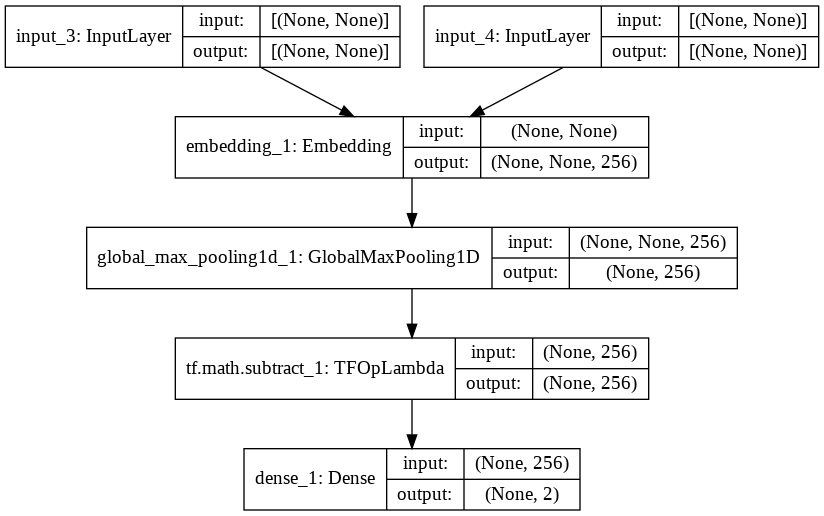

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(qp_dir, "type1.hdf5"), # qd_dir밑으로 type1 저장할게
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True) # 가끔가다 로딩이 잘 안될때가 있대
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(qp_dir, "type1.csv"))

In [ ]:
history = model.fit((train_inputs_1, train_inputs_2), train_labels,
                    epochs=100,
                    batch_size=512, # 사전학습할때는 큰게 좋고, task할때는 적은 값이 좋다
                    validation_data=((test_inputs_1, test_inputs_2), test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
1/1 [==============================] - 1s 991ms/step - loss: 0.6919 - accuracy: 0.5000 - val_loss: 0.6969 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/question_pair/type1.hdf5
Epoch 2/100
1/1 [==============================] - 0s 160ms/step - loss: 0.6787 - accuracy: 0.9000 - val_loss: 0.6976 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/100
1/1 [==============================] - 0s 111ms/step - loss: 0.6660 - accuracy: 1.0000 - val_loss: 0.6981 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/100
1/1 [==============================] - 0s 108ms/step - loss: 0.6537 - accuracy: 1.0000 - val_loss: 0.6988 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.50000
Epoch 5/100
1/1 [==============================] - 0s 164ms/step - loss: 0.6418 - accuracy: 1.0000 - val_loss: 0.

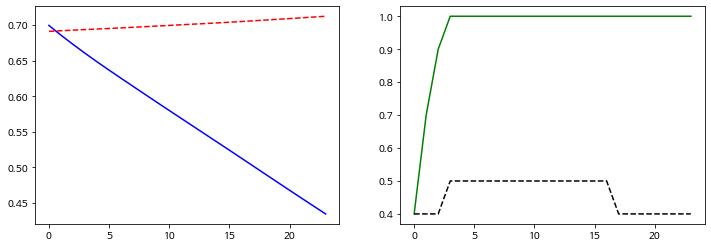

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(qp_dir, "type1.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate((test_inputs_1, test_inputs_2), test_labels)

# input으로 꼭 tuple로 줘야한다

1/1 [==============================] - 0s 170ms/step - loss: 0.6969 - accuracy: 0.5000


[0.6969453692436218, 0.5]

In [ ]:
y_pred = model.predict((test_inputs_1, test_inputs_2))
y_pred

# input으로 꼭 tuple로 줘야한다

array([[0.48296803, 0.51703197],
       [0.4866979 , 0.5133021 ],
       [0.5038641 , 0.49613592],
       [0.4938379 , 0.5061621 ],
       [0.5036498 , 0.49635023],
       [0.5054846 , 0.4945154 ],
       [0.49622536, 0.5037746 ],
       [0.4969108 , 0.5030892 ],
       [0.4927715 , 0.5072285 ],
       [0.5118374 , 0.48816258]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([1, 1, 0, 1, 0, 0, 1, 1, 1, 0])

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[4, 5],
       [0, 1]])

In [ ]:
# 꼭 confuse matrix 다확인해보자
# inbalance

tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.5
precision: 0.16666666666666666
recall: 1.0
f1: 0.2857142857142857


## 배포

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(qp_dir, "type1.hdf5"))

In [ ]:
string1 = "영화 너무 심심해"
string2 = "영화 너무 재미지고 좋았어"

In [ ]:
vocab.encode_as_pieces(string1), vocab.encode_as_pieces(string2)

(['▁영화', '▁너무', '▁심', '심', '해'], ['▁영화', '▁너무', '▁재미', '지고', '▁좋았', '어'])

In [ ]:
infer_input_1 = vocab.encode_as_ids(string1)
infer_input_1 = np.array([infer_input_1])
infer_input_1

array([[ 283, 2364,  732,  690,   61]])

In [ ]:
infer_input_2 = vocab.encode_as_ids(string2)
infer_input_2 = np.array([infer_input_2])
infer_input_2

array([[  283,  2364, 16850,  3132, 19271,   107]])

In [ ]:
y_pred = model.predict((infer_input_1, infer_input_2))
y_pred

array([[0.50408614, 0.49591386]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)[0]
y_class

0

In [ ]:
print(f"{string1} / {string2} : {id_to_label[y_class]}")

영화 너무 심심해 / 영화 너무 재미지고 좋았어 : 다른 질문


In [ ]:
def do_predict(model, string1, string2):
    infer_input_1 = vocab.encode_as_ids(string1)
    infer_input_1 = np.array([infer_input_1]) # [] 하는 이유는 batch size = 1이라는거지

    infer_input_2 = vocab.encode_as_ids(string2)
    infer_input_2 = np.array([infer_input_2])

    y_pred = model.predict((infer_input_1, infer_input_2))
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]
    # return y_class

In [ ]:
do_predict(model, string1, string2)

'다른 질문'

In [ ]:
while True:
    print("input 1> ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("input 2> ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    result = do_predict(model, string1, string2)
    print(result)

input 1> 어렵다 어려워
input 2> 너무 많이 먹엇네
다른 질문
input 1> 음
input 2> 
